# <font color='red'>ASSIGNMENT 2 SOLUTIONS, Fall 2022</font> 


# SCS 3546: Deep Learning
> Assignment 2: Classification of Flowers using Transfer Learning in Keras

### Your name & student number:

<pre> Please enter your name here. </pre>

<pre> Please enter your student number here. </pre>

# Instructions


**Please follow all instructions carefully:**

Download the small flower dataset (http://download.tensorflow.org/example_images/flower_photos.tgz, links to an external site). This dataset has 5 classes (Daisy, Dandelion, Rose, Sunflower, and Tulip). Images for each class are stored in its own folder. Note: if clicking on the above link does not trigger a download automatically, try copying the link into your browser. 

The images have different dimensions. Resize all of them to 150x150 pixel images. 

- (Note: VGG accepts 256x256 pixel images by default, but we can downsize this when loading VGG (see code snippet below), and this will save us training time by reducing dimensionality.)

Split images to 80-20% for training and test. Make sure you have the same distribution of flower types between train and test datasets. 
Note: your test set should be held out until final evaluation, after you have finished optimizing your model. When trying different hyperparameters, please cut a separate validation split (10-20% of total training set size) from your training data to assess generalization importance. This can be done either manually or by passing the `validation_split` parameter to `model.fit()`.  A single validation split will suffice, you do not need to use full K-fold cross-validation for this assignment. 

Use a VGG16 model (pre-trained on ImageNet) for transfer learning. Remove the top layers (fully connected layers). You can set VGG's expected input shape to the non-default value of (150, 150, 3) using the code snippet below, which also removes the top layers:

```python
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
```

Add your own fully connected layers (example: one with 256 nodes using ‘relu’ activation, and an output layer with 5 nodes and ‘softmax’ activation; the choice is up to you). You will train three different models and compare all three:

- **Model 1**: First, freeze all layers of VGG16, train only the layers you added on top of it, and evaluate the model. Try your best to improve the model performance, and explain the reason behind any choices you make. You should experiment with different hyperparameters, such as the number of neurons or layers, optimizer type, and so forth. You can also apply regularization, batch normalization, or data augmentation as you see fit. Please show all steps, so we can follow the progression of your improvements to the model. Evaluate your model. You should report training, validation, and test accuracy (all three).

- **Model 2**: Second, unfreeze the last block of VGG16 (block5), which corresponds to the final four layers. Re-train and evaluate the model. You can keep the same set of best hyperparameters that you found while optimizing Model 1, or try new hyperparameters, it's up to you. 

- **Model 3**: Third, unfreeze all the layers and try again. Evaluate your model. 

Compare the accuracy achieved between all three cases. Which one is better and why? Offer an explanation as to why performance is either better or worse in each case.



# Grading Scheme

15 points total:

- Data Preparation (1 point)
  - Data should be programatically resized to the appropriate dimensions, normalized, and the class distributions in your train and test datasets should be balanced. 

- Model 1 (5 points)
  - We expect you to put effort into optimizing this model. Show all your work so we can follow your progression. 

- Model 2 (3 points)

- Model 3 (3 points)

- Model Comparison (1 point)
  - Provide reasoning behind why you think each model performed better or worse. 

- Explanations and Interpretations (2 points)
  - Code should be clearly commented and easy to follow; explain your rationale behind all decisions, such as choice of hyperparameters; results should be explained and interpreted in context with the assignment objectives. 

# Your Work Below
***

In [1]:
# import dependencies

import cv2
import os
import joblib

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model, Sequential                 
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    Input,
    GlobalAveragePooling2D,
)                   
from sklearn.utils import class_weight
from sklearn.metrics import (
    roc_curve, 
    roc_auc_score, 
    confusion_matrix, 
    accuracy_score
)
from sklearn.model_selection import train_test_split

### Download Flower Dataset and Train-Val-Test Split

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 2s 0us/step


In [4]:
batch_size = 32
img_height = 150
img_width = 150

# this will resize the images as it loads them, 
# and returns a Tensorflow Dataset
ds_all = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 3670 files belonging to 5 classes.


In [5]:
# to keep things simple and not have to worry about the nuances of dealing
# with tensorflow datasets, and because this is a small dataset that fits entirely
# in memory, I'm going to load this dataset into memory, so I'm dealing with simple list
# and array objects

# this pulls the full dataset into memory
# and will return a list of batches
X_in_memory = []
y_in_memory = []

for X, y in ds_all.as_numpy_iterator():
 X_in_memory.append(X)
 y_in_memory.append(y)

print(f"Number of batches: {len(X_in_memory)}")
print(f"Batch Size: {len(X_in_memory[0])}")
print(f"Sample Dimensions: {X_in_memory[0][0].shape}")

# now let's convert this from a list of batches into 
# a list of samples, which we can easily split into
# train, val, and test sets and process as usual

# there are more elegant and efficient ways of reshaping this, 
# but I'll use a straightforward method for clarity:

X_data = []
for batch_id in range(len(X_in_memory)):
  for sample_id in range(len(X_in_memory[batch_id])):
    X_data.append(X_in_memory[batch_id][sample_id])

y_data = []
for batch_id in range(len(y_in_memory)):
  for sample_id in range(len(y_in_memory[batch_id])):
   y_data.append(y_in_memory[batch_id][sample_id])

print(f"Size of X_data: {len(X_data)}")
print(f"Size of y_data: {len(y_data)}")
print(f"Dimensions of X_data samples: {X_data[0].shape}")
print(f"Tail of y_data (shows class labels): {y_data[-5:]}")


Number of batches: 115
Batch Size: 32
Sample Dimensions: (150, 150, 3)
Size of X_data: 3670
Size of y_data: 3670
Dimensions of X_data samples: (150, 150, 3)
Tail of y_data (shows class labels): [4, 3, 0, 4, 0]


In [8]:
# normalize the data
X_data = [img/255 for img in X_data]

In [11]:
X_data[0].min()

0.0

In [10]:
X_data[0].max()

0.9981235

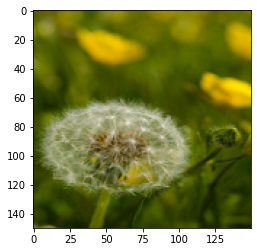

In [7]:
# let's plot one of our samples, as a sanity check
plt.imshow(X_data[0])
plt.show()

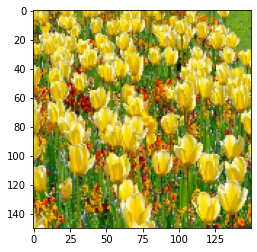

In [14]:
# and another one!
plt.imshow(X_data[9])
plt.show()

In [51]:
# train / val / test split
X_train_val, X_test, y_train_val, y_test = train_test_split(
  X_data, 
  y_data, 
  test_size=0.20, 
  random_state=99, 
  shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
  X_train_val, 
  y_train_val, 
  test_size=0.20, 
  random_state=99, 
  shuffle=True
)


In [52]:
# let's check the class distributions
# compute class label ratios per dataset

from collections import Counter

ratios = {}
for key, labels in zip(["train", "val", "test"], [y_train, y_val, y_test]):
  counts = dict(Counter(labels)) # count num occurences per class label
  total = sum(counts.values(), 0.0) # count total number of labels
  ratios_dict = {k: v / total for k, v in counts.items()} # get normalized ratio
  ratios_list = [ratios_dict[index] for index in range(5)] # return as label-sorted list
  ratios[key] = ratios_list

ratios

{'train': [0.174190800681431,
  0.2393526405451448,
  0.17844974446337308,
  0.1848381601362862,
  0.2231686541737649],
 'val': [0.18027210884353742,
  0.2568027210884354,
  0.16156462585034015,
  0.1989795918367347,
  0.20238095238095238],
 'test': [0.16076294277929154,
  0.25204359673024523,
  0.17302452316076294,
  0.2016348773841962,
  0.2125340599455041]}

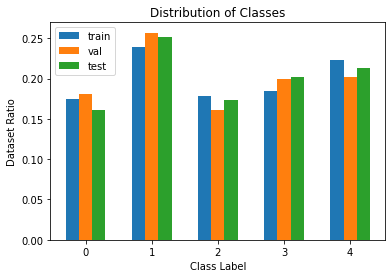

In [53]:
# plot the distribution
X_axis = np.arange(len(ratios["train"]))

plt.bar(X_axis - 0.2, ratios["train"], 0.2, label = 'train')
plt.bar(X_axis, ratios["val"], 0.2, label = 'val')
plt.bar(X_axis + 0.2, ratios["test"], 0.2, label = 'test')
  
plt.xticks(X_axis, [0, 1, 2, 3, 4])
plt.xlabel("Class Label")
plt.ylabel("Dataset Ratio")
plt.title("Distribution of Classes")
plt.legend()
plt.show()

In [ ]:
# We see that we achieve reasonable balance between the train, val, and test datasets, 
# in terms of frequency per class. However, we do have a class imbalance between the
# classes themselves, for example, we have more images from class "1" than class "0"

## Model 1: All VGG Layers Frozen
***

In [60]:
from keras import applications
tf.keras.backend.clear_session()

# our images are 150-by-150 pixels, with 3 colour channels; we can actually
# modify VGG16 to accept this (150, 150, 3) shape as we load it
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


58889256/58889256 [==============================] - 3s 0us/step


In [91]:
# this helper function will unfreeze the number of layers we specify
def unfreeze_top_layers(model, num_layers=None):
    
    # first make all the layers trainable 
    for layer in model.layers:
        layer.trainable = True 

    # freeze the specified number of layers
    if not num_layers:
        for layer in model.layers:
            layer.trainable = False  # freeze all
    else:
        # skip the specified number of final layers and freeze ther est
        for layer in model.layers[:-num_layers]:
            layer.trainable = False

    return model

Since we are dealing with imbalanced data we should pass class weights while we are training model 

In [55]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer

# reference: https://towardsdatascience.com/dealing-with-imbalanced-data-in-tensorflow-class-weights-60f876911f99
def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class 
  or multi-label labels, both one-hot-encoded or not.

  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}

    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}

    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}

    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}

  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, 
  the class_label would be index of appareance of the label when the dataset was processed. 

  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  
  Author: Angel Igareta (angel@igareta.com)

  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

In [57]:
# applying the above function
class_weights_train = generate_class_weights(y_train)
class_weights_val = generate_class_weights(y_val)
class_weights_test = generate_class_weights(y_test)

class_weights_train

{0: 1.148166259168704,
 1: 0.8355871886120997,
 2: 1.120763723150358,
 3: 1.0820276497695853,
 4: 0.8961832061068702}

### Now Let's Build and Train the Classifier!

In [62]:
VGG_frozen_all = unfreeze_top_layers(base_model, num_layers = None)

classifier_1 = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(150, 150, 3)), # some basic data augmentation
    layers.experimental.preprocessing.RandomRotation(0.2), # some basic data augmentation
    VGG_frozen_all,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_initializer="he_normal"),
    Dense(5, activation='softmax', kernel_initializer="glorot_normal") # output layer is softmax, num units = num classes
])

classifier_1.build(input_shape=(None, 150, 150, 3))


In [63]:
# compile
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
classifier_1.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])
classifier_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 150, 150, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 150, 150, 3)      0         
 tation)                                                         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 5)                

In [74]:
# note: our X_data is still a list of arrays; we need an array of arrays
# when we call .fit()

X_train = np.stack(X_train, axis=0)
X_val = np.stack(X_val, axis=0)
X_test = np.stack(X_test, axis=0)

X_train.shape


(2348, 150, 150, 3)

In [76]:
y_train = np.stack(y_train, axis=0)
y_val = np.stack(y_val, axis=0)
y_test = np.stack(y_test, axis=0)

y_train.shape


(2348,)

In [77]:
# train with early stopping
patience = 10
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True)

history = classifier_1.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_cb], 
    class_weight=class_weights_train
)


Epoch 1/100
74/74 [==============================] - 21s 137ms/step - loss: 5.9280 - accuracy: 0.3271 - val_loss: 3.1996 - val_accuracy: 0.5255
Epoch 2/100
74/74 [==============================] - 10s 138ms/step - loss: 3.0067 - accuracy: 0.5166 - val_loss: 2.1843 - val_accuracy: 0.6259
Epoch 3/100
74/74 [==============================] - 9s 116ms/step - loss: 2.2421 - accuracy: 0.5911 - val_loss: 1.7923 - val_accuracy: 0.6616
Epoch 4/100
74/74 [==============================] - 9s 119ms/step - loss: 1.8583 - accuracy: 0.6448 - val_loss: 1.5767 - val_accuracy: 0.6888
Epoch 5/100
74/74 [==============================] - 9s 116ms/step - loss: 1.5609 - accuracy: 0.6784 - val_loss: 1.5650 - val_accuracy: 0.6888
Epoch 6/100
74/74 [==============================] - 9s 116ms/step - loss: 1.4848 - accuracy: 0.6899 - val_loss: 1.4005 - val_accuracy: 0.7177
Epoch 7/100
74/74 [==============================] - 10s 132ms/step - loss: 1.2292 - accuracy: 0.7159 - val_loss: 1.2831 - val_accuracy: 0.7

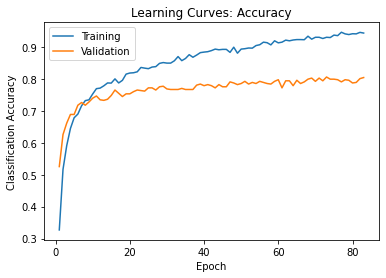

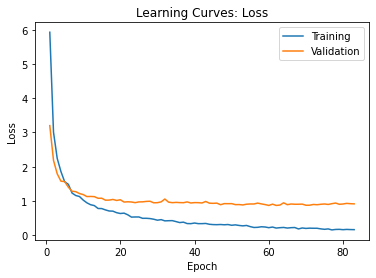

In [81]:
# let's look at learning curves to 
# examine training

def plot_learning_curves(history):
  """Plots learning curves from model training. 
  """

  # plot accuracies
  y_train_accuracy = history.history['accuracy']
  y_val_accuracy = history.history['val_accuracy']
  x = [epoch for epoch in range(1, len(y_train_accuracy) + 1)]

  plt.plot(x, y_train_accuracy, label = "Training")
  plt.plot(x, y_val_accuracy, label = "Validation")
  plt.legend()

  plt.xlabel("Epoch")
  plt.ylabel("Classification Accuracy")
  plt.title("Learning Curves: Accuracy")

  plt.show()

  # plot loss
  y_train_loss = history.history['loss']
  y_val_loss = history.history['val_loss']
  x = [epoch for epoch in range(1, len(y_train_loss) + 1)]

  plt.plot(x, y_train_loss, label = "Training")
  plt.plot(x, y_val_loss, label = "Validation")
  plt.legend()

  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Learning Curves: Loss")

  plt.show()


plot_learning_curves(history)

In [ ]:
# from the learning curves above, our validation performance plateaus pretty quickly, 
# and while it does not degrade, the growing gap between the training and validation 
# scores suggests we might be overfitting our data

In [82]:
# What were the final metrics?
print("Train loss, Train acc:", classifier_1.evaluate(X_train, y_train))
print("Val loss, Val acc:", classifier_1.evaluate(X_val, y_val))
print("Test loss, Test acc:", classifier_1.evaluate(X_test, y_test))

74/74 [==============================] - 6s 78ms/step - loss: 0.2258 - accuracy: 0.9216
Train loss, Train acc: [0.225760355591774, 0.9216354489326477]
19/19 [==============================] - 1s 76ms/step - loss: 0.8885 - accuracy: 0.8061
Val loss, Val acc: [0.8884651064872742, 0.8061224222183228]
23/23 [==============================] - 3s 145ms/step - loss: 0.9812 - accuracy: 0.7847
Test loss, Test acc: [0.9811818599700928, 0.7847411632537842]


In [78]:
# Not Shown: Hyperparameter Tuning
# 
# You can experiment with any of the following to try to further optimize the model performance:
# 
# - Number of dense layers
# - Size of dense layers
# - Choice of activation function
# - Use of Batch Normalization
# - Use of Dropout
# - Choice of optimizer


## Model 2: VGG, Unfrozen Block 5
***



In the VGG16 architecture, there are five blocks in total: the first two blocks have two Conv layers, each followed by ReLU and MaxPool layers; the last three have three Conv layers, each followed by ReLU and MaxPool layers. Image taken from (Das et al., 2018).

Since we've already pulled the dense layers off, we'll want to unfreeze the top 4 layers.

![VGG16 Diagram](https://www.researchgate.net/profile/Alex-Ter-Sarkisov/publication/338572801/figure/fig1/AS:847202364686336@1579000192000/VGG16-architecture-There-are-in-total-five-blocks-the-first-two-blocks-have-two-Conv.jpg)





In [92]:
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

VGG_unfrozen_block_5 = unfreeze_top_layers(base_model, num_layers=4)

# we'll also print the layer names and show whether or not 
# they have been unfrozen, to convince ourselves we have done this correctly
for layer in VGG_unfrozen_block_5.layers:
  print(f"Layer Name: {layer.name}; Unfrozen: {layer.trainable}")


Layer Name: input_3; Unfrozen: False
Layer Name: block1_conv1; Unfrozen: False
Layer Name: block1_conv2; Unfrozen: False
Layer Name: block1_pool; Unfrozen: False
Layer Name: block2_conv1; Unfrozen: False
Layer Name: block2_conv2; Unfrozen: False
Layer Name: block2_pool; Unfrozen: False
Layer Name: block3_conv1; Unfrozen: False
Layer Name: block3_conv2; Unfrozen: False
Layer Name: block3_conv3; Unfrozen: False
Layer Name: block3_pool; Unfrozen: False
Layer Name: block4_conv1; Unfrozen: False
Layer Name: block4_conv2; Unfrozen: False
Layer Name: block4_conv3; Unfrozen: False
Layer Name: block4_pool; Unfrozen: False
Layer Name: block5_conv1; Unfrozen: True
Layer Name: block5_conv2; Unfrozen: True
Layer Name: block5_conv3; Unfrozen: True
Layer Name: block5_pool; Unfrozen: True


In [94]:

classifier_2 = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(150, 150, 3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    VGG_unfrozen_block_5,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu',kernel_initializer="he_normal"),
    Dense(5, activation='softmax',kernel_initializer="glorot_normal")
])

classifier_2.build(input_shape=(None, 150, 150, 3))


In [95]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
classifier_2.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])
classifier_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 150, 150, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 150, 150, 3)      0         
 tation)                                                         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 5)                

In [96]:
# train with early stopping
patience = 10
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True)

history = classifier_2.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_cb], 
    class_weight=class_weights_train
)


Epoch 1/100
74/74 [==============================] - 12s 138ms/step - loss: 1.3945 - accuracy: 0.5447 - val_loss: 0.6993 - val_accuracy: 0.7364
Epoch 2/100
74/74 [==============================] - 10s 132ms/step - loss: 0.6367 - accuracy: 0.7653 - val_loss: 0.6329 - val_accuracy: 0.7721
Epoch 3/100
74/74 [==============================] - 10s 135ms/step - loss: 0.5077 - accuracy: 0.8126 - val_loss: 0.5500 - val_accuracy: 0.8163
Epoch 4/100
74/74 [==============================] - 11s 143ms/step - loss: 0.4219 - accuracy: 0.8450 - val_loss: 0.6104 - val_accuracy: 0.7857
Epoch 5/100
74/74 [==============================] - 10s 133ms/step - loss: 0.3873 - accuracy: 0.8526 - val_loss: 0.4347 - val_accuracy: 0.8469
Epoch 6/100
74/74 [==============================] - 10s 130ms/step - loss: 0.3266 - accuracy: 0.8795 - val_loss: 0.4681 - val_accuracy: 0.8197
Epoch 7/100
74/74 [==============================] - 10s 130ms/step - loss: 0.2768 - accuracy: 0.8931 - val_loss: 0.5600 - val_accuracy:

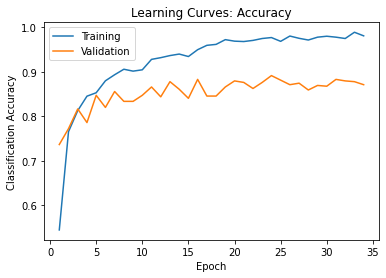

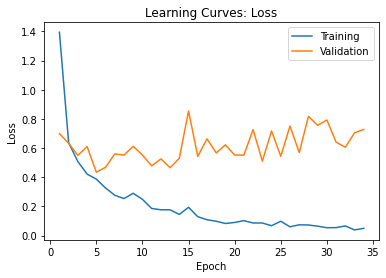

In [97]:
plot_learning_curves(history)

In [ ]:
# We see that val accuracy was higher than before, 
# but training looks less stable (probably because we are starting to 
# detune VGG), and the validation loss is starting to creep up, 
# indicating overfitting might be setting in.

# Compared to model 1, we have a higher training accuracy, so probably bias
# has decreased, which is why we can still get a higher validation accuracy
# even though variance (overfitting) has not improved. 

In [98]:
# What were the final metrics?
print("Train loss, Train acc:", classifier_2.evaluate(X_train, y_train))
print("Val loss, Val acc:", classifier_2.evaluate(X_val, y_val))
print("Test loss, Test acc:", classifier_2.evaluate(X_test, y_test))

74/74 [==============================] - 6s 79ms/step - loss: 0.0612 - accuracy: 0.9851
Train loss, Train acc: [0.06121434271335602, 0.9850937128067017]
19/19 [==============================] - 2s 78ms/step - loss: 0.7176 - accuracy: 0.8912
Val loss, Val acc: [0.7175667881965637, 0.8911564350128174]
23/23 [==============================] - 2s 81ms/step - loss: 0.5306 - accuracy: 0.8978
Test loss, Test acc: [0.5305596590042114, 0.8978201746940613]


## Model 3: VGG, All Unfrozen
***


In [99]:
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [100]:
num_layers = len(base_model.layers)

In [102]:
VGG_unfrozen_all = unfreeze_top_layers(base_model, num_layers=num_layers)

In [103]:
# all layers should be unfrozen
for layer in VGG_unfrozen_all.layers:
  print(f"Layer Name: {layer.name}; Unfrozen: {layer.trainable}")

Layer Name: input_4; Unfrozen: True
Layer Name: block1_conv1; Unfrozen: True
Layer Name: block1_conv2; Unfrozen: True
Layer Name: block1_pool; Unfrozen: True
Layer Name: block2_conv1; Unfrozen: True
Layer Name: block2_conv2; Unfrozen: True
Layer Name: block2_pool; Unfrozen: True
Layer Name: block3_conv1; Unfrozen: True
Layer Name: block3_conv2; Unfrozen: True
Layer Name: block3_conv3; Unfrozen: True
Layer Name: block3_pool; Unfrozen: True
Layer Name: block4_conv1; Unfrozen: True
Layer Name: block4_conv2; Unfrozen: True
Layer Name: block4_conv3; Unfrozen: True
Layer Name: block4_pool; Unfrozen: True
Layer Name: block5_conv1; Unfrozen: True
Layer Name: block5_conv2; Unfrozen: True
Layer Name: block5_conv3; Unfrozen: True
Layer Name: block5_pool; Unfrozen: True


In [104]:
classifier_3 = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(150, 150, 3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    VGG_unfrozen_all,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu',kernel_initializer="he_normal"),
    Dense(5, activation='softmax',kernel_initializer="glorot_normal")
])

classifier_3.build(input_shape=(None, 150, 150, 3))


In [105]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
classifier_3.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])
classifier_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (None, 150, 150, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 150, 150, 3)      0         
 tation)                                                         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 5)                

In [106]:
# train with early stopping
patience = 10
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True)

history = classifier_3.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_cb], 
    class_weight=class_weights_train
)


Epoch 1/100
74/74 [==============================] - 24s 275ms/step - loss: 1.6041 - accuracy: 0.3727 - val_loss: 1.2413 - val_accuracy: 0.4677
Epoch 2/100
74/74 [==============================] - 19s 251ms/step - loss: 1.0209 - accuracy: 0.5822 - val_loss: 0.8823 - val_accuracy: 0.6054
Epoch 3/100
74/74 [==============================] - 19s 254ms/step - loss: 0.7363 - accuracy: 0.7027 - val_loss: 0.8317 - val_accuracy: 0.6684
Epoch 4/100
74/74 [==============================] - 19s 253ms/step - loss: 0.5975 - accuracy: 0.7679 - val_loss: 0.6438 - val_accuracy: 0.7500
Epoch 5/100
74/74 [==============================] - 19s 254ms/step - loss: 0.5136 - accuracy: 0.8101 - val_loss: 0.6061 - val_accuracy: 0.7925
Epoch 6/100
74/74 [==============================] - 19s 254ms/step - loss: 0.4622 - accuracy: 0.8233 - val_loss: 0.7245 - val_accuracy: 0.7840
Epoch 7/100
74/74 [==============================] - 19s 259ms/step - loss: 0.4341 - accuracy: 0.8301 - val_loss: 0.5426 - val_accuracy:

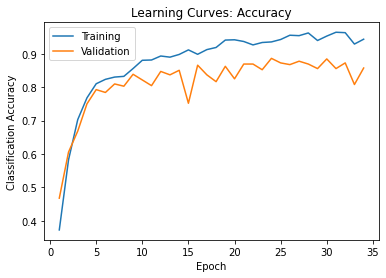

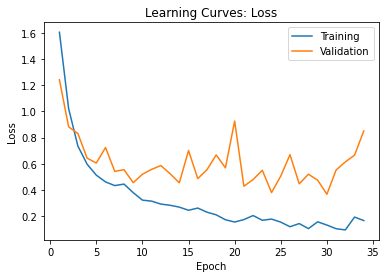

In [107]:
plot_learning_curves(history)

In [108]:
# What were the final metrics?
print("Train loss, Train acc:", classifier_3.evaluate(X_train, y_train))
print("Val loss, Val acc:", classifier_3.evaluate(X_val, y_val))
print("Test loss, Test acc:", classifier_3.evaluate(X_test, y_test))

74/74 [==============================] - 6s 81ms/step - loss: 0.0878 - accuracy: 0.9727
Train loss, Train acc: [0.08776389062404633, 0.9727427363395691]
19/19 [==============================] - 2s 79ms/step - loss: 0.3809 - accuracy: 0.8861
Val loss, Val acc: [0.38090184330940247, 0.8860543966293335]
23/23 [==============================] - 2s 82ms/step - loss: 0.2750 - accuracy: 0.9046
Test loss, Test acc: [0.27495262026786804, 0.9046321511268616]


In [ ]:
# Like model 2, there is some instability in the loss. But the training
# curves are similar. The val and test accuracies are slightly higher for
# model 3, but this might not be statistically signifcant.

## Model Comparison
***

In [110]:
acc_1 = classifier_1.evaluate(X_test, y_test)[1]
acc_2 = classifier_2.evaluate(X_test, y_test)[1]
acc_3 = classifier_3.evaluate(X_test, y_test)[1]

print("Test Accuracy with VGG All Frozen (Model 1):", acc_1)
print("Test Accuracy with VGG Block 5 Unfrozen (Model 2):", acc_2)
print("Test Accuracy with VGG All Unfrozen (Model 3):", acc_3)

23/23 [==============================] - 2s 77ms/step - loss: 0.2750 - accuracy: 0.9046
Test Accuracy with VGG All Frozen (Model 1): 0.7929155230522156
Test Accuracy with VGG Block 5 Unfrozen (Model 2): 0.8978201746940613
Test Accuracy with VGG All Unfrozen (Model 3): 0.9046321511268616


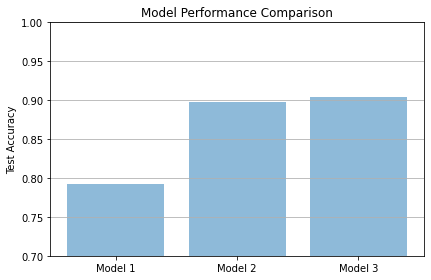

In [112]:
def plot_model_accuracies(accuracies, model_names, y_range=(0.70, 1.0)):

  # build the plot
  x_pos = np.arange(len(model_names))
  fig, ax = plt.subplots()
  ax.bar(x_pos, 
        accuracies,
        align='center',
        alpha=0.5,
        ecolor='black',
        capsize=10)
  ax.set_ylabel('Test Accuracy')
  ax.set_xticks(x_pos)
  ax.set_xticklabels(model_names)
  ax.set_title('Model Performance Comparison')
  ax.yaxis.grid(True)

  # display
  plt.tight_layout()
  plt.ylim(y_range)
  plt.show()

plot_model_accuracies(accuracies=[acc_1, acc_2, acc_3], model_names=["Model 1", "Model 2", "Model 3"])

Based on our experiments, unfreezing all VGG layers (Model 3) gave the best results, although the small difference of 0.6 percent compared to Model 2 might not be statistically significant. We'd have to perform K-fold cross-validation to obtain mean scores and their variances to be sure. 

It's not terribly surprising that models 2 and 3 outperform model 1. By unfreezing some of the VGG conv layers, we are fine-tuning its weights and learned features to our specific problem, and taking advantage of greater representational power. 

Going from model 1 to models 2 and 3, we still see some evidence of overfitting, however we have clearly reduced the bias (since the training accuracy improved), which accounts for our boost in validation accuracy. 

We saw that the learning curves looked less stable in models 2 and 3 compared to model 1. This could be a side-effect of detuning the original VGG learned features. 

It's rather surprising that unfreezing the entire model did as well as we observed. Our training dataset of only ~3000 images is quite small. It could be that the initial conditions provided by the VGG weights were still quite good, and the gradient updates applied to them were quite small. If we continued to train, rather than halting via the early stopping callback, it's possible we might start to see significant performance degradation in Model 3 as overfitting gets worse. 